# CUDA Accelerated Code - I took the code I wrote for CPU and asked chatGPT to accelerate it for me using CUDA, and the turnaround time was exponentially improved. I aslo asked it to write functions instead of rerunning the same code each time.

In [12]:
# damped_driven_pendulum_gpu.py
"""
GPU-accelerated utilities for the classic damped, driven pendulum.

Prerequisites
-------------
conda install numba cupy scipy matplotlib
# --or--
pip install numba cupy-cuda12x scipy matplotlib
"""

import math
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from scipy.integrate import solve_ivp       # only used for the 1-γ histogram
import cupy as cp                           # only used in histogram

# --------------------------------------------------------------------------- #
#                              GPU RK4 kernel                                 #
# --------------------------------------------------------------------------- #
@cuda.jit
def rk4_dense_kernel(gammas, dt, steps_burn, steps_keep, stride, theta_out):
    """
    Each thread integrates one γ value from t=0 → t_end.
    After `steps_burn` it stores θ every `stride` steps (1 sample = stride·dt s)
    for `steps_keep/stride` samples.

    Parameters
    ----------
    gammas      : 1-D device array of γ
    dt          : time step
    steps_burn  : # steps to integrate before we start recording
    steps_keep  : # steps during which we record
    stride      : store θ every `stride` steps
    theta_out   : 2-D device array [n_γ, n_samples]
    """
    i = cuda.grid(1)
    if i >= gammas.size:
        return

    g  = gammas[i]
    w  = 2.0 * math.pi
    w0 = 1.5 * w
    b  = 0.25 * w0

    # initial state (θ, θ̇, φ)
    th, thd, ph = 0.5 * math.pi, 0.0, 0.0

    # ---- helper: RHS -------------------------------------------------------
    def rhs(theta, theta_dot, phi):
        return (
            theta_dot,
            g * w0 * w0 * math.cos(phi) - 2.0 * b * theta_dot - w0 * w0 * math.sin(theta),
            w,
        )

    # ---- integrate burn-in -------------------------------------------------
    for _ in range(steps_burn):
        k1t, k1d, k1p = rhs(th, thd, ph)
        k2t, k2d, k2p = rhs(th + 0.5 * dt * k1t, thd + 0.5 * dt * k1d, ph + 0.5 * dt * k1p)
        k3t, k3d, k3p = rhs(th + 0.5 * dt * k2t, thd + 0.5 * dt * k2d, ph + 0.5 * dt * k2p)
        k4t, k4d, k4p = rhs(th + dt * k3t,     thd + dt * k3d,     ph + dt * k3p)
        th  += dt / 6.0 * (k1t + 2*k2t + 2*k3t + k4t)
        thd += dt / 6.0 * (k1d + 2*k2d + 2*k3d + k4d)
        ph  += dt / 6.0 * (k1p + 2*k2p + 2*k3p + k4p)

    # ---- record phase ------------------------------------------------------
    samples = theta_out.shape[1]
    store_idx = 0
    for step in range(steps_keep):
        k1t, k1d, k1p = rhs(th, thd, ph)
        k2t, k2d, k2p = rhs(th + 0.5 * dt * k1t, thd + 0.5 * dt * k1d, ph + 0.5 * dt * k1p)
        k3t, k3d, k3p = rhs(th + 0.5 * dt * k2t, thd + 0.5 * dt * k2d, ph + 0.5 * dt * k2p)
        k4t, k4d, k4p = rhs(th + dt * k3t,     thd + dt * k3d,     ph + dt * k3p)
        th  += dt / 6.0 * (k1t + 2*k2t + 2*k3t + k4t)
        thd += dt / 6.0 * (k1d + 2*k2d + 2*k3d + k4d)
        ph  += dt / 6.0 * (k1p + 2*k2p + 2*k3p + k4p)

        if step % stride == stride - 1 and store_idx < samples:
            theta_out[i, store_idx] = (th + math.pi) % (2.0 * math.pi) - math.pi
            store_idx += 1

# --------------------------------------------------------------------------- #
#                        High-level convenience wrappers                      #
# --------------------------------------------------------------------------- #
def integrate_gammas(
    gammas,
    t_end=500.0,
    dt=0.01,
    burn_time=400.0,
    sample_every=1.0,
):
    """
    GPU-integrate many γ values and return flattened θ plus repeated γ.

    Returns
    -------
    gamma_rep : flattened 1-D array of γ (len = n_γ × n_samples)
    theta     : flattened 1-D array of wrapped θ
    """
    gammas = np.asarray(gammas, dtype=np.float64)
    steps_tot  = int(t_end / dt)
    steps_burn = int(burn_time / dt)
    steps_keep = steps_tot - steps_burn
    stride     = int(sample_every / dt)
    n_samples  = steps_keep // stride

    d_g      = cuda.to_device(gammas)
    d_theta  = cuda.device_array((gammas.size, n_samples), dtype=np.float64)

    threads = 128
    blocks  = (gammas.size + threads - 1) // threads
    rk4_dense_kernel[blocks, threads](d_g, dt, steps_burn, steps_keep, stride, d_theta)

    theta_flat = d_theta.copy_to_host().ravel()
    gamma_rep  = np.repeat(gammas, n_samples)
    return gamma_rep, theta_flat


def plot_orbit_diagram(
    gammas,
    vertical_line=None,
    sweep_name="sweep",
    **integ_kwargs,
):
    γ_rep, θ = integrate_gammas(gammas, **integ_kwargs)

    plt.figure(figsize=(10, 5))
    plt.scatter(γ_rep, θ, s=2)
    if vertical_line is not None:
        plt.axvline(vertical_line, color="red", ls="--", label=fr"$\gamma = {vertical_line}$")
        plt.legend()
    plt.xlabel(r"$\gamma$")
    plt.ylabel(r"$\theta$ (rad)")
    plt.title(f"Orbit diagram – {sweep_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def histogram_theta(
    gamma,
    t_end=3100.0,
    dt=0.01,
    burn_time=100.0,
    n_random=3000,
    bins=100,
):
    """
    CPU solve for a single γ, GPU-accelerated histogram comparison.
    """
    # --- SciPy solve --------------------------------------------------------
    def rhs(t, v, g):
        w  = 2*np.pi
        w0 = 1.5*w
        b  = 0.25*w0
        th, thd, ph = v
        return [
            thd,
            g*w0*w0*np.cos(ph) - 2*b*thd - w0*w0*np.sin(th),
            w,
        ]

    t_span = (0.0, t_end)
    IC     = [np.pi/2, 0.0, 0.0]
    sol    = solve_ivp(rhs, t_span, IC, args=(gamma,),
                       rtol=1e-9, atol=1e-12, max_step=0.01,
                       dense_output=True)

    t_samples = np.arange(burn_time, t_end, 1.0)   # exactly as before
    θ_samples = sol.sol(t_samples)[0]

    # --- GPU random + histogram --------------------------------------------
    θ_gpu   = cp.asarray(θ_samples)
    rng_gpu = cp.random.default_rng()
    rand_gpu= rng_gpu.uniform(θ_gpu.min(), θ_gpu.max(), n_random)

    bins_gpu   = cp.linspace(θ_gpu.min(), θ_gpu.max(), bins + 1)
    hist_θ     = cp.histogram(θ_gpu,   bins=bins_gpu)[0]
    hist_rand  = cp.histogram(rand_gpu, bins=bins_gpu)[0]

    # --- Plot ---------------------------------------------------------------
    bins_cpu = cp.asnumpy(bins_gpu)
    plt.figure(figsize=(10, 5))
    width = bins_cpu[1] - bins_cpu[0]
    plt.bar(bins_cpu[:-1], cp.asnumpy(hist_θ),   width=width, alpha=0.7, label=r'$\theta(t)$')
    plt.bar(bins_cpu[:-1], cp.asnumpy(hist_rand),width=width, alpha=0.5, label='Uniform random')
    plt.xlabel(r'$\theta$ (rad)')
    plt.ylabel('Count')
    plt.title(fr'Histogram at $\gamma={gamma}$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





# Problem 8b WIDE sweep 

/home/kimaruboruett/Documents/Swarthmore/spring-2025/nonlinear-dynamics-chaos/labs/venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


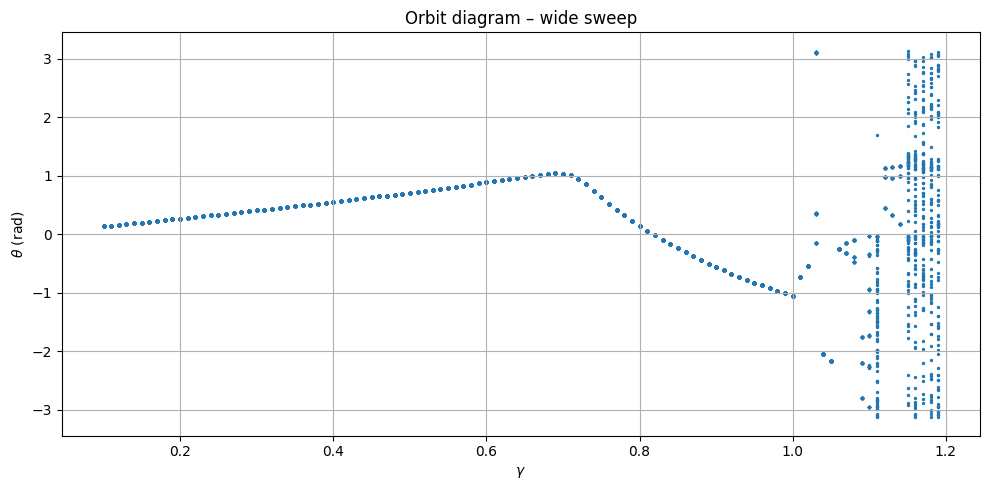

In [13]:
plot_orbit_diagram(
    gammas=np.arange(0.10, 1.20, 0.01),
    sweep_name="wide sweep",
    burn_time=400.0,    # last 100 s will be plotted
)


In [14]:
# Problem 8c MEDIUM sweep 

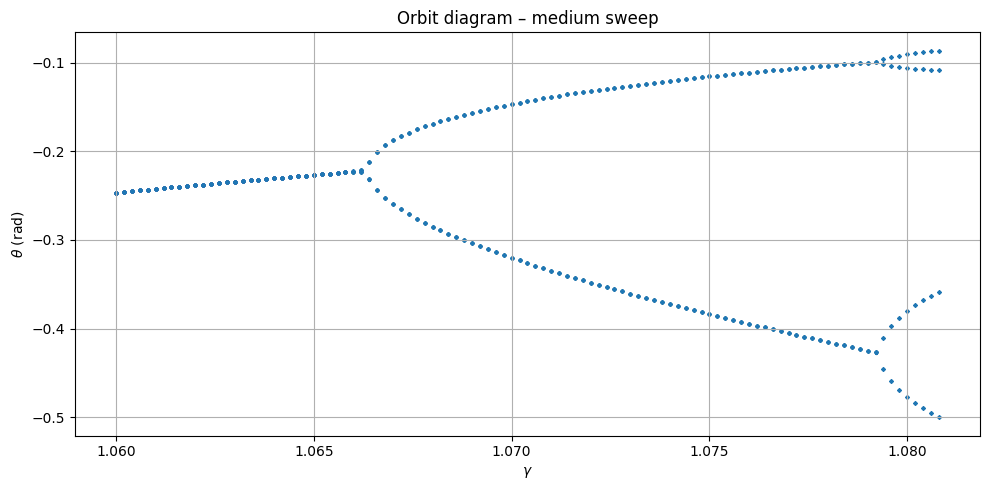

In [15]:
plot_orbit_diagram(
    gammas=np.arange(1.060, 1.081, 0.0002),
    sweep_name="medium sweep",
    burn_time=400.0,
)

# Problem 8d NARROW sweep + vertical line

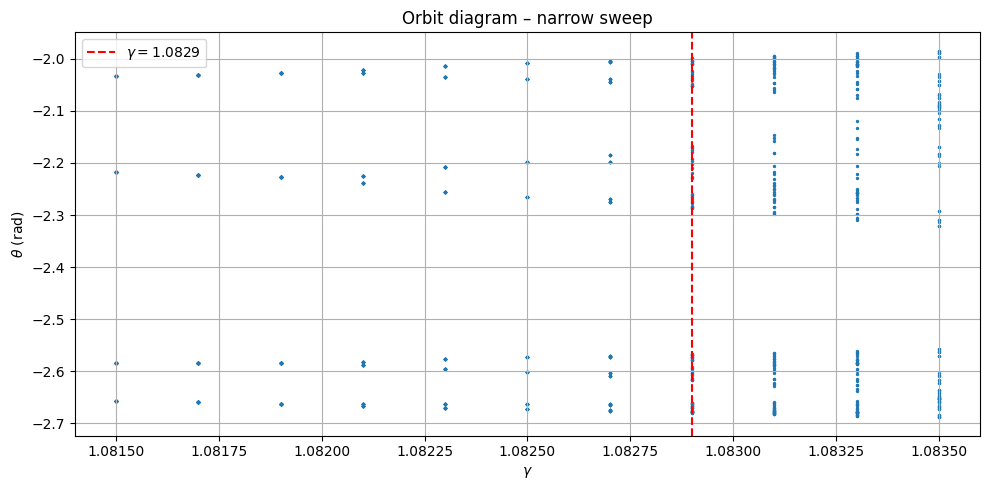

In [16]:
plot_orbit_diagram(
    gammas=np.arange(1.0815, 1.0836, 0.0002),
    vertical_line=1.0829,
    sweep_name="narrow sweep",
    burn_time=400.0,
)


# Problem 8e Histogram for γ = 1.086

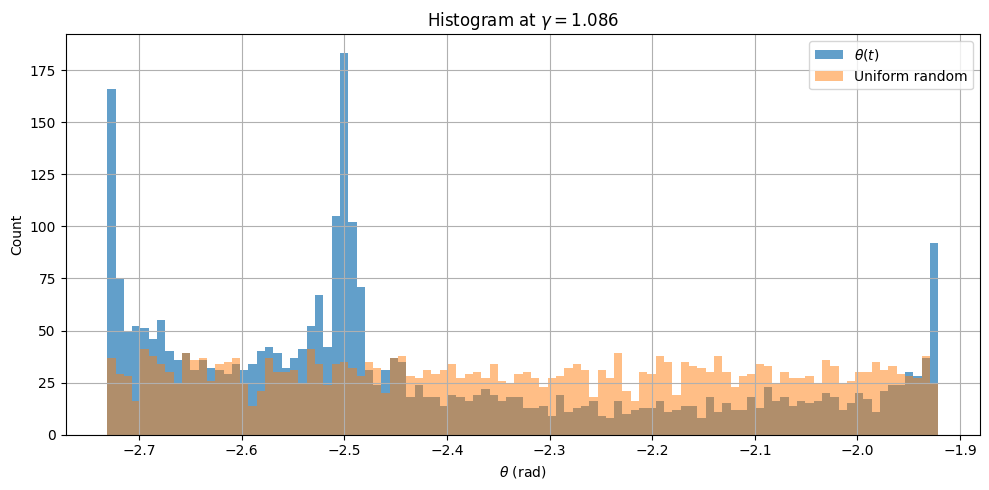

In [17]:
histogram_theta(gamma=1.086)

# Problem 8e Histogram for γ = 1.200

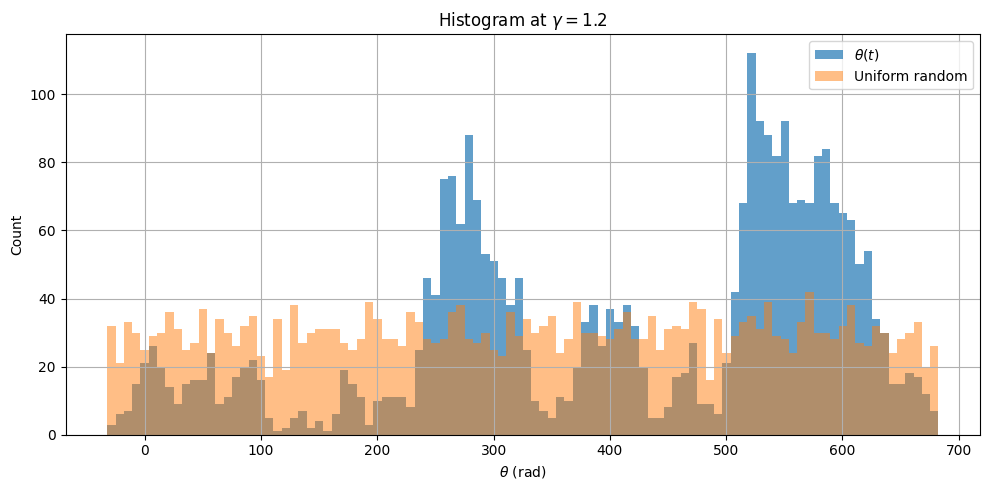

In [18]:
histogram_theta(gamma=1.200)